### Setting up

We are going to pre-assign the path locations so that it's easier to work with.
Next we are going to choose our model. For this demo, we are using SSD Mobnet. You can find the list of all the tensorflow models out there. They are most commonly known as [**Tensorflow model zoo**](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)

**NOTE:** The exclaimation mark before any commands means that it will be run by your operating system shell instead of python. 

Ref: https://youtu.be/yqkISICHH-U?t=6117

In [2]:
import os

In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [4]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow_Images', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow_Images','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow_Images','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow_Images', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow_Images', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow_Images', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow_Images', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow_Images', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow_Images', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow_Images', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow_Images', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow_Images','protoc')
 }

In [5]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow_Images', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [7]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'nt':
            !mkdir {path}

We are going to put the TF record files in the `annotation` folder. The `models` folder will contain our model files which we will clone the tensorflow repo in a bit.

### 01. Download Pretrained Models and Install TFOD
This is the most difficult part. Too much stuff to do. 

**Object detection tf**: https://github.com/tensorflow/models/tree/master/research/object_detection

First, we install wget which is a library to retrieve files through HTTP from the internet.

Next, we are going to clone this tf repo into our `Tensorflow_Images/models` folder.

Ref: https://www.tensorflow.org/install/source_windows


In [8]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Next, we do 4 things:
1. Install `Protoc` using wget [ref](https://developers.google.com/protocol-buffers/docs/overview)
2. Move the downloaded zip file to the protoc file path and extract
3. Add the protoc bin folder into your environment path system variable
4. Finally cd into the tensorflow folder and install

**Note:** It takes forever to download these

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow_Images/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow_Images/models/research/slim && pip install -e .

Now, run this verification script to check if everything is installed.

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

**NOTE:** Install tensor flow if the above script shows that tensorflow not installed. In my case, it worked. Similarly, install all required packages if it throws any error.

In [ ]:
conda list

In [9]:
import object_detection

Now we are going to leverage the existing pre-trained model and use it. We can find the [URL](http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz) from the tensorflow model zoo.

In [ ]:
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

### 02. Create label map
Now we are gonna create a label map. It contains all the labels of the model we are going to train

In [15]:
labels = [{'name':'ThumbsUp', 'id':1}, {'name':'LiveLong', 'id':2}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

### 03. Create TF Records

TFRecords are binary formatted files for storing data. Using TFRecords will help speed up training for our custom object detection model


In [ ]:
# OPTIONAL IF RUNNING ON COLAB
# SKIP THIS IF YOU ARE NOT USING COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

The above script clones a python script which we can use to convert files to TFRecords format. Now we are going to convert our images to that format and put them inside `Tensorflow_Images\workspace\annotations`

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')}

### 04. Copy Model Config to Training Folder

We are copying the pipeline.config file to our custom model folder. The `pipeline.config` file contains the information about the architecture of the model (which in this case is the ssd_mobilenet).

If we open that pipeline.config file, we will see that some of the values are defined as *PATH_TO_BE_CONFIGURED*. This means we have to input those fields when training our model.

`train_input_reader`: will contain the train TFRecord file

`eval_input_reader`: will contain the test TFRecord file

In [29]:
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


### 05. Update Config for our Custom model

In this part, we are inputting those fields with the value *PATH_TO_BE_CONFIGURED*.

In [10]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [11]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [12]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)

In [17]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [18]:
# finally write them into the file
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)

### 06. Training the model

Now the fun part. 
We are going to use the `model_main_tf2.py` file to train our custom model. So, we provide our config file as well and indicate the dir path. We also use `num_train_steps` as 2000. For finalized models, increase this value to 10k or 20k.

In [19]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [20]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [21]:
print(command)
# copy this output and run it in a cmd to track the progress

python Tensorflow_Images\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow_Images\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow_Images\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=2000


**NOTE**: It's better to execute the command in the command shell. Since we cant keep track of the progress in this notebook.

In [ ]:
!{command}

Error: you may need to reinstall some packages before running the command.


### 07. Evaluate the Model

In [22]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [23]:
print(command)

python Tensorflow_Images\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow_Images\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow_Images\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow_Images\workspace\models\my_ssd_mobnet


In [ ]:
!{command}

Running the above command will generate an evaluation matrix and show us the accuracy of the model. 

If we go to our custom model folder in `C:\Users\Swapnil\Desktop\Machine Learning\Computer Vision\object_detection\Tensorflow_Images\workspace\models\my_ssd_mobnet`, we will see that we have 2 folders: `eval` and `train`. The eval folder contains our test data set and the train contains our training set. We can open these for visualization in **tensorboard**. Tensorboard is a GUI. 

to run tensorboard, cd into the eval folder or the train folder and type
```bash
tensorboard --logdir=.
```
And then navigate to http://localhost:6006/

###  08. Load Train Model From Checkpoint

In [28]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [33]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint.
# NOTE: ckpt-3 is my latest checkpoint. This can change. So number them accordingly.
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

### 09. Detect from static image

In [34]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

Add a dummy static image

In [39]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'thumbsup.77d7745a-152e-11ec-a8a2-40167e70ea98.jpg')

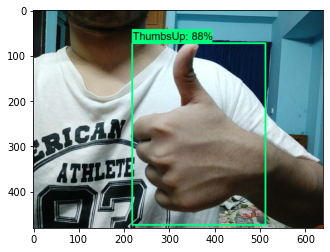

In [40]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

### 10. Realtime detections

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

### 11. Freezing the model

Now, we can export our model to any app of our choice, may it be an android application or webapp. But first we have to [freeze](https://stats.stackexchange.com/questions/393168/what-does-it-mean-to-freeze-or-unfreeze-a-model) the model. 

We freeze the model and export the TFJS and TFLite files into their designated folders.


In [6]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [7]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [8]:
print(command)

python Tensorflow_Images\models\research\object_detection\exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow_Images\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow_Images\workspace\models\my_ssd_mobnet --output_directory=Tensorflow_Images\workspace\models\my_ssd_mobnet\export


In [ ]:
!{command}

### 12. Conversion to TFJS

We now export our entire machine learning model to a json file. We can use this file in our webapp which may be REACTjs

In [ ]:
!pip install tensorflowjs

In [11]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [12]:
print(command)

tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default Tensorflow_Images\workspace\models\my_ssd_mobnet\export\saved_model Tensorflow_Images\workspace\models\my_ssd_mobnet\tfjsexport


In [ ]:
!{command}

Navigate to `Tensorflow_Images\workspace\models\my_ssd_mobnet\export\saved_model Tensorflow_Images\workspace\models\my_ssd_mobnet\tfjsexport` and see that we have a model.json file now. This file contains the entire machine learning model.

### 12. Conversion to TFLite

TensorFlow Lite is TensorFlow's lightweight solution for mobile and embedded devices. It lets you run machine-learned models on mobile devices with low latency, so you can take advantage of them to do classification, regression or anything else you might want without necessarily incurring a round trip to a server


In [14]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')


In [15]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [16]:
print(command)

python Tensorflow_Images\models\research\object_detection\export_tflite_graph_tf2.py  --pipeline_config_path=Tensorflow_Images\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow_Images\workspace\models\my_ssd_mobnet --output_directory=Tensorflow_Images\workspace\models\my_ssd_mobnet\tfliteexport


In [ ]:
!{command}

In [18]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [19]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [20]:
print(command)

tflite_convert --saved_model_dir=Tensorflow_Images\workspace\models\my_ssd_mobnet\tfliteexport\saved_model --output_file=Tensorflow_Images\workspace\models\my_ssd_mobnet\tfliteexport\saved_model\detect.tflite --input_shapes=1,300,300,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=FLOAT --allow_custom_ops


In [ ]:
!{command}

### 13. Zip and Export Models

In [22]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}